### QED-C Application-Oriented Benchmarks - Hamiltonian Simulation with HamLib - GSEE / VQE

The notebook contains specific examples for the HamLib-based Hamiltonian Simulation benchmark program.
Configure and run the cell below with the desired execution settings.
Then configure and run the remaining cell(s), each one a variation of this benchmark.

This example illustrates finding the ground state energy of a Hamiltonian extracted from the specified HamLib dataset.
It uses a typical classical optimizer to itertively execute a parameterized quantum ansatz kernel and to progressively adjust the ansatz parameters to find the lowest energy state for the Hamiltonian.

Currently this example operates on only one fixed size for each type of Hamiltonian and produces plots representing the evolution of the optimization.



### Program Configuration

In [ ]:
# Select the API to use and load the benchmark program
api = "qiskit"
from hamlib import hamlib_simulation_benchmark

# Select the benchmark parameters
num_qubits = min_qubits = max_qubits = 4
skip_qubits=1
max_circuits=1
num_shots=10000

# Select the backend 
#backend_id="qasm_simulator"
backend_id="statevector_simulator"
provider_backend=None
exec_options={}

#############

# place resulting data and images into a folder with "paper" suffix
from _common import metrics
metrics.data_suffix = "_vqe"
hamlib_simulation_benchmark.data_suffix = "_vqe"


In [ ]:
import numpy as np
from math import sin, cos, pi
import time

# Import HamLib helper functions (from _common)
from hamlib._common import hamlib_utils

# Import Hamlib Simulation kernel (from qiskit)
from hamlib._common import hamlib_simulation_kernel

# Import Observable helper functions
from hamlib._common import observables
from hamlib._common import evolution_exact

verbose = True

#### for executing circuits to compute observables ...

# Import Qiskit and Qiskit Pauli operator classes
#from qiskit.quantum_info import Pauli, SparsePauliOp
#from qiskit import QuantumCircuit

# Initialize simulator backend
#from qiskit_aer import Aer
#backend = Aer.get_backend('qasm_simulator')


### List of Available Hamiltonians and Sizes
For the example illustrated below, select one of the available Hamiltonian (name, params, size) tuples.


In [3]:
# list of observable computation methods to sweep
group_method_list = [ None, "simple", "N", "estimator" ]

# List of HamLib filename and parameter tuples, with max_qubits limit array
# Note that the 4th entry in the array is used in the cell below which executes a noisy simulation
hamiltonians = [
    ('condensedmatter/tfim/tfim', { "1D-grid": "pbc", "h": 2 }, [24,28,28,28, 16] ),
    ('condensedmatter/heisenberg/heis', { "1D-grid": "pbc", "h": 2 }, [24,28,28,28, 16] ),
    ('condensedmatter/fermihubbard/FH_D-1', { "1D-grid": "pbc", "enc": "bk", "U":12 }, [20,24,24,24, 14] ),
    ('condensedmatter/bosehubbard/BH_D-1_d-4', { "1D-grid": "nonpbc", "enc": "gray", "U":10 }, [16,24,24,24, 12] ),
    ('binaryoptimization/max3sat/random/random_max3sat-hams', { "ratio": "2", "rinst": "02" }, [18,28,28,28, 14] ),
    ('chemistry/electronic/standard/H2', { "ham_BK": "" }, [8,12,12,12, 8] )
    ]

# Select indices of the Hamiltonian(s) to test
ham_indexes = range(len(hamiltonians))       # select all
#ham_indexes = [2,3]       # select subset, for example 2,3; for quick test, do just one of them

# limit testing to simple for now
group_method = "simple"

# just do TFIM for now
ham_indexes = [ 0 ]

# get Hamiltonian name and params from list
# Note: we will loop over multiples here later
hamiltonian_name, hamiltonian_params, _ = hamiltonians[0]

print(f"\n*******************************************************************************************")

print(f"\nHamiltonianGSEE / VQE Example for {hamiltonian_name} {hamiltonian_params}\n")

print("============================================================\n")
print(f"Testing expectation grouping method: {group_method}\n") 



*******************************************************************************************

HamiltonianGSEE / VQE Example for condensedmatter/tfim/tfim {'1D-grid': 'pbc', 'h': 2}


Testing expectation grouping method: simple



### Load the Given Hamiltonian to get its Pauli terms

In [4]:
# load the HamLib file for the given hamiltonian name
hamlib_utils.load_hamlib_file(filename=hamiltonian_name)

# return a sparse Pauli list of terms queried from the open HamLib file
sparse_pauli_terms, dataset_name = hamlib_utils.get_hamlib_sparsepaulilist(num_qubits=num_qubits, params=hamiltonian_params)
print(f"... dataset_name = {dataset_name}")
print(f"... sparse_pauli_terms = \n{sparse_pauli_terms}")

print("")

... dataset_name = graph-1D-grid-pbc-qubitnodes_Lx-4_h-2
... sparse_pauli_terms = 
[({0: 'Z', 1: 'Z'}, (1+0j)), ({0: 'Z', 3: 'Z'}, (1+0j)), ({1: 'Z', 2: 'Z'}, (1+0j)), ({3: 'Z', 2: 'Z'}, (1+0j)), ({0: 'X'}, (2+0j)), ({1: 'X'}, (2+0j)), ({3: 'X'}, (2+0j)), ({2: 'X'}, (2+0j))]



### Arrange Pauli Terms into Commuting Groups

In [5]:
# Arrange the Pauli terms into commuting groups based on group_method, for use in cells below
pauli_term_groups, pauli_str_list = hamlib_simulation_benchmark.find_pauli_groups(num_qubits, sparse_pauli_terms, group_method)

print(f"... Number of groups created: {len(pauli_term_groups)}")
print(f"... Pauli Term Groups:")
for group in pauli_term_groups:
    print(group)
        


... finished grouping terms, total grouping time = 0.0 sec.

... Number of groups created: 2
... Pauli Term Groups:
[('ZZII', (1+0j)), ('ZIIZ', (1+0j)), ('IZZI', (1+0j)), ('IIZZ', (1+0j))]
[('XIII', (2+0j)), ('IXII', (2+0j)), ('IIIX', (2+0j)), ('IIXI', (2+0j))]


### Ansatz Definition - Suitable Quantum Circuit for Initial State
Select the type of ansatz circuit to use

In [6]:
import numpy as np
from qiskit.circuit.library import EfficientSU2
from qiskit import QuantumCircuit

def get_ansatz(num_qubits, params):
    ansatz = EfficientSU2(num_qubits).decompose()
    ansatz.barrier()

    params_dict = {p: params[i] for i, p in enumerate(ansatz.parameters)}

    # Use assign_parameters instead of bind_parameters
    ansatz = ansatz.assign_parameters(params_dict)
    
    return ansatz

# Create the ansatz
ansatz = EfficientSU2(num_qubits)

num_params = ansatz.num_parameters

# Generate initial parameters with correct length
initial_params = np.random.uniform(-np.pi, np.pi, ansatz.num_parameters)
print(initial_params)

# Get the ansatz circuit
ansatz_circuit = get_ansatz(num_qubits, initial_params)
print(ansatz_circuit)


[ 0.307  1.352  0.646  0.282 -0.48   0.917 -0.392  2.462  2.913 -0.732
  1.833  0.182  0.428  2.674 -2.695 -2.594 -3.015  2.09   1.748  2.325
  3.007  1.88  -0.242  1.763 -2.398  0.879 -2.241  2.794  0.137 -0.536
 -1.479  1.723]
      ┌────────────┐┌──────────────┐                                   »
q_0: ─┤ Ry(0.3067) ├┤ Rz(-0.47969) ├───────────────────────────■───────»
      ├────────────┤├─────────────┬┘                         ┌─┴─┐     »
q_1: ─┤ Ry(1.3521) ├┤ Rz(0.91668) ├─────────────■────────────┤ X ├─────»
     ┌┴────────────┤├─────────────┴┐          ┌─┴─┐      ┌───┴───┴───┐ »
q_2: ┤ Ry(0.64568) ├┤ Rz(-0.39215) ├──■───────┤ X ├──────┤ Ry(1.833) ├─»
     ├─────────────┤└┬────────────┬┘┌─┴─┐┌────┴───┴────┐┌┴───────────┴┐»
q_3: ┤ Ry(0.28201) ├─┤ Rz(2.4616) ├─┤ X ├┤ Ry(0.18155) ├┤ Rz(-2.5941) ├»
     └─────────────┘ └────────────┘ └───┘└─────────────┘└─────────────┘»
«      ┌────────────┐ ┌─────────────┐                            »
«q_0: ─┤ Ry(2.9133) ├─┤ Rz(0.42754) ├──────────

### Create Measurement Circuits from Base Circuit and Pauli Terms
Here, we append basis rotation gates for each Pauli Term group to the base evolution circuit to create an array of circuits for execution.

In [7]:
# generate an array of circuits, one for each pauli_string in list
def create_measurement_circuts(qc, num_qubits, pauli_term_groups, pauli_str_list):
    ts = time.time()
    
    circuits = hamlib_simulation_kernel.create_circuits_for_pauli_terms(qc, num_qubits, pauli_str_list)
    """
    print(f"... Appended {len(circuits)} circuits, one for each group:")               
    for circuit, group in list(zip(circuits, pauli_term_groups)):
        print(group)
        #print(circuit)
    """
    append_time = round(time.time()-ts, 3)
    ###print(f"\n... finished appending {len(circuits)} measurement circuits, total creating time = {append_time} sec.\n")

    return circuits


In [8]:
def do_execute(circuits, num_shots):
    
    # Initialize simulator backend
    from qiskit_aer import Aer
    backend = Aer.get_backend('qasm_simulator')
    #backend = Aer.get_backend('statevector_simulator')     # doesn't work, only returns 1 shot
    
    ### print(f"... begin executing {len(circuits)} circuits ...")
    ts = time.time()
    
    # Execute all of the circuits to obtain array of result objects
    results = backend.run(circuits, num_shots=num_shots).result()

    #for ca in results.get_counts():
    #    print(ca)
    
    exec_time = round(time.time()-ts, 3)
    ###print(f"... finished executing {len(circuits)} circuits, total execution time = {exec_time} sec.\n")

    return results


In [9]:
# Compute the total energy for the Hamiltonian
def compute_energy(num_qubits, results, pauli_term_groups):

    ###print(f"... begin computing observable value ...")
    ts = time.time()
    
    total_energy, term_contributions = observables.calculate_expectation_from_measurements(
                                                num_qubits, results, pauli_term_groups)
    obs_time = round(time.time()-ts, 3)
    ###print(f"... finished computing observable value, computation time = {obs_time} sec.\n")
    
    #print(f"    Total Energy: {round(np.real(total_energy), 4)}")
    ### print(f"    Term Contributions: {term_contributions}\n")

    create_time = 0
    group_time = 0
    append_time = 0
    exec_time = 0
    
    total_time = group_time + create_time + append_time + exec_time + obs_time
    total_time = round(total_time, 3)
    ###print(f"\n... total observable computation time = {total_time} sec.\n")
    
    return total_energy


### Define the Objective Function for the Classical Optimizer (Cost Function)
Now we specify the objective function which takes as input a list of the ansatz' parameters, and returns the cost associated with those parameters. The cost is determined by exeuting the ansatz with those parameters and computes a cost function based on the measurement distribution returned.

In the case of VQE, the ansatz needs to be executed once for each term of the Hamiltonian, with basis rotations applied at the end of the ansatz. The total energy is the sum of the weighted energy computation over all the terms. The goal is to find the parameters that result in the lowest 'total energy'. 

In [10]:
# keep track of the number of iterations performed
count = 0

tracker_style = 1     # controls style of output printed each iteration - 1 - dots, 2 - detailed

# Return the cost associated with the ansatz and the given parameters over the problem Hamiltonian
def objective_function(params):
    global count
    count += 1

    #print(f"... executing on num_qubits = {num_qubits}")
    
    # Create a quantum ansatz circuit with the given parameters (update later to use Parameter)
    qc = get_ansatz(num_qubits, params)  

    #print(qc)

    # Append measurement circuits for each term group and return an array of circuits
    circuits = create_measurement_circuts(qc, num_qubits, pauli_term_groups, pauli_str_list)

    #for c in circuits:
    #    print(c)

    results = do_execute(circuits, num_shots)

    energy = compute_energy(num_qubits, results, pauli_term_groups)
    energy = np.real(energy)
    
    # print important data at each iteration (the cost and the associated parameter values)
    if tracker_style > 1:
        print(f"  {count:3} \t{energy: <7.5}  \t{[round(params[i], 4) for i in range(len(params))]} ")
    else:
        print(".", end='')
        
    return energy
    

In [11]:
energy = objective_function(initial_params)

print(f"... energy = {round(energy, 4)}")



.... energy = -1.6523


### Execute the VQE Algorithm to Find the Optimal Parameters.
Create an instance of the selected optimizer, and run the algorithm. Note that the output varies from run to run. Moreover, while close, the obtained distribution might not be exactly the same as the target distribution, however, increasing the number of shots taken will increase the accuracy of the output.

In [12]:
from scipy.optimize import minimize

# Select the optimizer to use
#method = 'SLSQP'
#method = 'Nelder-Mead'
method = 'COBYLA'
maxiter = 1000

# Store an array of lowest energy results for each backend tested
energy_results = {}

backend_label = "qasm_simulator"
energy_results[backend_label] = []

global count
count = 0

# Create the initial parameters to match length of parameters
#params = np.random.rand(num_params)
params = np.random.uniform(-np.pi, np.pi, num_params)
#params = [ 0.0 ] * num_params

#if initial_point is not None:
#    params = initial_point

"""
params = [ 0.796,  1.81,  -2.172, -0.073,  1.512,  0.663,  3.564,  2.174, -0.597,  0.531,
  0.819, -2.563, -0.023,  1.089, -1.769, -1.134, -1.17,   0.032,  1.591, -1.017,
  2.857, -2.575, -1.474, -2.07,   1.019, -1.485,  0.032, -1.951, -2.635, -1.455,
  0.727, -2.568]


params = [-3.271,  0.42,   2.234, -1.482,  2.693, -1.957,  2.97,6 -0.229,  3.262,  1.133,
  3.021, -2.983, -0.174, -1.789, -1.699, -1.632,  0.048, -1.138, -1.603,  0.754,
  0.135, -2.327, -0.405, -1.187, 1.139,  3.11,  -1.236,  2.349, -2.958,  0.905,
 -0.915, -2.514]

  [-3.271  0.42   2.234 -1.482  2.693 -1.957  2.976 -0.229  3.262  1.133
  3.021 -2.983 -0.174 -1.789 -1.699 -1.632  0.048 -1.138 -1.603  0.754
  0.135 -2.327 -0.405 -1.187  1.139  3.11  -1.236  2.349 -2.958  0.905
 -0.915 -2.514]

 [ 0.7    1.74  -2.18  -0.132  1.531  0.602  3.509  3.178 -0.575  0.52
  0.781 -2.714 -0.07   1.068 -1.839 -1.15  -1.223  0.011  1.573 -1.038
  2.856 -2.626 -1.527 -2.136  1.005 -1.489 -0.011 -1.981 -2.666 -1.498
  0.693 -2.578]
 
"""
initial_point = params

print(f"... init point = {initial_point}")

# Print header above output from execution
if tracker_style > 1:
    print("  Iter\tEnergy\t\tParams")

# Iterate over multiple executions of the objective_function to obtain lowest energy
result = minimize(objective_function, initial_point, method=method, options = { 'maxiter': maxiter} )

# store the resulting energy from this VQE execution
energy_results[backend_label].append(result.fun)

#print(f"\nExecution on backend = {backend}")
print(f"\nFinal Result:{result}")

print(f"\nLowest Ground State Energy: ", result.fun)
print("Parameters Found: ", result.x)
print("Total Iterations: ", result.nfev)

print("... continue ...")


... init point = [-0.276  0.43  -3.024  0.739  0.704  0.735  2.788  1.142 -0.883 -0.396
  1.242 -2.763  1.048  1.072 -1.82  -2.332 -1.16  -0.856  0.441 -0.386
  3.069 -2.5   -1.829 -2.128  0.962 -1.55  -0.212 -1.606 -2.143 -2.448
  0.982 -2.273]
.........................................................................................................................................................................................................................................................................................................................................
Final Result: message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -5.01953125
       x: [ 9.299e-01  1.293e+00 ...  4.861e-01 -2.546e+00]
    nfev: 329
   maxcv: 0.0

Lowest Ground State Energy:  -5.01953125
Parameters Found:  [ 0.93   1.293 -2.797  0.972  1.244  0.686  4.164  2.476 -0.957  0.607
  0.783 -2.884  0.408  0.727 -1.943 -1.328 -1.649 -0.656  1.832 -0.918
  2.539 -2.8   -1.773 -

In [13]:
import os
import json

#testname = "outFileGSsolver_n28_k18_m886_id6669736531"

testname = "outFileGSsolver_n8_k8_m39_id3418257666"   # 4 -> 8 qubits

filename = "itayfiles/" + "ham_" + testname + ".json"
  
co_data = None

# attempt to load metrics data from file
if os.path.exists(filename) and os.path.isfile(filename):
    with open(filename, 'r') as f:
        
        # attempt to load shared_data dict as json
        try:
            co_data = json.load(f)

        except json.JSONDecodeError as e:
            print(f"ERROR: Failed to parse JSON file {filename}\n{e}")
            
        except:
            print(f"ERROR: cannot load file {f}")

sparse_pauli_terms = co_data

print(f"... loaded Hamiltonian with {len(sparse_pauli_terms)} terms.")

# Convert qubit indices back to integer
for term in sparse_pauli_terms:
    print(term)
    new_qs = {}
    for k, v in term[0].items():
        new_qs.update({int(k):v})
        
    term[0] = new_qs
        
#print(sparse_pauli_terms)

... loaded Hamiltonian with 39 terms.
[{}, 20.0]
[{'0': 'Z', '1': 'Z', '2': 'X', '3': 'Y', '4': 'X', '5': 'X', '6': 'X', '7': 'X'}, 0.24999999999999994]
[{'1': 'Z', '2': 'X', '4': 'Z', '5': 'Y'}, 0.06698729810778066]
[{'0': 'Y', '1': 'Z', '2': 'Z', '3': 'X', '5': 'Z', '6': 'X', '7': 'Y'}, 0.12940952255126037]
[{'0': 'Y', '1': 'Z', '3': 'X', '5': 'Z', '6': 'X', '7': 'Y'}, -0.12940952255126037]
[{'1': 'Z', '2': 'Y', '3': 'X', '4': 'X'}, 0.9330127018922193]
[{'0': 'Z', '1': 'Z', '2': 'Y', '3': 'Z', '4': 'Z', '5': 'Z', '6': 'X', '7': 'X'}, -0.24999999999999994]
[{'0': 'X', '1': 'Z', '3': 'Y', '5': 'Y', '7': 'Z'}, 0.48296291314453416]
[{'0': 'X', '1': 'Z', '2': 'Z', '3': 'Y', '5': 'Y', '7': 'Z'}, -0.48296291314453416]
[{'0': 'X', '1': 'Z', '2': 'Y', '3': 'Y', '4': 'Z', '5': 'Z', '6': 'Y', '7': 'Y'}, -0.24999999999999994]
[{'0': 'Y', '1': 'Z', '2': 'Y', '4': 'X', '6': 'Z', '7': 'Z'}, -0.9330127018922193]
[{'0': 'Z', '1': 'Z', '2': 'Z', '3': 'Z', '5': 'Y', '6': 'Z'}, -0.48296291314453416]
[{'

### Reconfigure for 8 qubits


In [14]:
min_qubits = max_qubits = num_qubits = 8

# Arrange the Pauli terms into commuting groups based on group_method, for use in cells below
pauli_term_groups, pauli_str_list = hamlib_simulation_benchmark.find_pauli_groups(num_qubits, sparse_pauli_terms, group_method)

print(f"... Number of groups created: {len(pauli_term_groups)}")
print(f"... Pauli Term Groups:")
for group in pauli_term_groups:
    print(group)


# Create the ansatz
ansatz = EfficientSU2(num_qubits)

num_params = ansatz.num_parameters

# Generate initial parameters with correct length
initial_params = np.random.uniform(-np.pi, np.pi, ansatz.num_parameters)
print(initial_params)

# Get the ansatz circuit
ansatz_circuit = get_ansatz(num_qubits, initial_params)
print(ansatz_circuit)




... finished grouping terms, total grouping time = 0.001 sec.

... Number of groups created: 25
... Pauli Term Groups:
[('IIIIIIII', 20.0), ('ZZXYXXXX', 0.24999999999999994)]
[('IZXIZYII', 0.06698729810778066), ('XZIYIYIZ', 0.48296291314453416)]
[('YZZXIZXY', 0.12940952255126037), ('YZIXIZXY', -0.12940952255126037), ('IIZIIIII', 5.0)]
[('IZYXXIII', 0.9330127018922193), ('YZYIXIZZ', -0.9330127018922193)]
[('ZZYZZZXX', -0.24999999999999994)]
[('XZZYIYIZ', -0.48296291314453416)]
[('XZYYZZYY', -0.24999999999999994)]
[('ZZZZIYZI', -0.48296291314453416), ('ZZIZIYZI', 0.48296291314453416)]
[('YZXXZYZZ', -0.06698729810778066)]
[('XZXZXXYY', -0.24999999999999994)]
[('IZIIIZYX', -0.12940952255126037), ('IZZIIZYX', 0.12940952255126037)]
[('YIIIYYZZ', -5.0)]
[('ZYXXYYZY', -0.48296291314453416), ('ZYXIIIZY', -0.48296291314453416)]
[('IYXZIXYZ', 0.12940952255126037)]
[('YYZYZIZX', 0.25000000000000006), ('YYIYZIZX', -0.25000000000000006)]
[('IYXYYZYZ', -0.12940952255126037)]
[('YYIZXYZX', -0.2500000

In [15]:
from scipy.optimize import minimize

# Select the optimizer to use
#method = 'SLSQP'
#method = 'Nelder-Mead'
method = 'COBYLA'
maxiter = 1000

# Store an array of lowest energy results for each backend tested
energy_results = {}

backend_label = "qasm_simulator"
energy_results[backend_label] = []

global count
count = 0

# Create the initial parameters to match length of parameters
#params = np.random.rand(num_params)
params = np.random.uniform(-np.pi, np.pi, num_params)
#params = [ 0.0 ] * num_params

#if initial_point is not None:
#    params = initial_point

"""
params = [ 0.796,  1.81,  -2.172, -0.073,  1.512,  0.663,  3.564,  2.174, -0.597,  0.531,
  0.819, -2.563, -0.023,  1.089, -1.769, -1.134, -1.17,   0.032,  1.591, -1.017,
  2.857, -2.575, -1.474, -2.07,   1.019, -1.485,  0.032, -1.951, -2.635, -1.455,
  0.727, -2.568]


params = [-3.271,  0.42,   2.234, -1.482,  2.693, -1.957,  2.97,6 -0.229,  3.262,  1.133,
  3.021, -2.983, -0.174, -1.789, -1.699, -1.632,  0.048, -1.138, -1.603,  0.754,
  0.135, -2.327, -0.405, -1.187, 1.139,  3.11,  -1.236,  2.349, -2.958,  0.905,
 -0.915, -2.514]

  [-3.271  0.42   2.234 -1.482  2.693 -1.957  2.976 -0.229  3.262  1.133
  3.021 -2.983 -0.174 -1.789 -1.699 -1.632  0.048 -1.138 -1.603  0.754
  0.135 -2.327 -0.405 -1.187  1.139  3.11  -1.236  2.349 -2.958  0.905
 -0.915 -2.514]

 [ 0.7    1.74  -2.18  -0.132  1.531  0.602  3.509  3.178 -0.575  0.52
  0.781 -2.714 -0.07   1.068 -1.839 -1.15  -1.223  0.011  1.573 -1.038
  2.856 -2.626 -1.527 -2.136  1.005 -1.489 -0.011 -1.981 -2.666 -1.498
  0.693 -2.578]
 
"""
initial_point = params

print(f"... init point = {initial_point}")

# Print header above output from execution
if tracker_style > 1:
    print("  Iter\tEnergy\t\tParams")

# Iterate over multiple executions of the objective_function to obtain lowest energy
result = minimize(objective_function, initial_point, method=method, options = { 'maxiter': maxiter} )

# store the resulting energy from this VQE execution
energy_results[backend_label].append(result.fun)

#print(f"\nExecution on backend = {backend}")
print(f"\nFinal Result:{result}")

print(f"\nLowest Ground State Energy: ", result.fun)
print("Parameters Found: ", result.x)
print("Total Iterations: ", result.nfev)

print("... continue ...")


... init point = [ 1.006 -1.319  0.742 -0.448 -2.29  -1.267  0.44   0.571  0.467  0.963
  0.956 -0.431  2.492 -0.832 -0.403  2.463  1.924  1.281 -2.512  2.636
  1.346  3.134 -2.203  2.313 -2.121  0.726 -2.364  2.187  1.931  0.434
 -0.583 -2.707  1.24  -0.292  1.395  2.302  2.988  2.236 -3.068 -0.88
  1.445 -2.063  0.132 -2.8   -1.885 -3.025  1.845 -1.735 -0.972  2.69
  1.284 -2.942 -2.107  0.763  0.485 -1.647  2.728  0.716  0.224  0.565
  1.446 -1.182 -0.639 -1.823]
...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................
Final Result: message: Optimization terminated successfully.
 success

### Compute Statistics on Results 
Here we compute the average and standard deviation from the repeated execution on each backend

In [16]:
print("\n*************************************")
print(f"Lowest Ground State Energies computed on these backends:")
er_averages = []
er_stddevs = []
for backend_label in energy_results:
    er = energy_results[backend_label]
    print(f"  {backend_label:24} = {er}")
    print(f"  {'':24}   avg={np.average(er):<7.5} std={np.std(er):<7.5}")
    
    er_averages.append(np.average(er))
    er_stddevs.append(np.std(er))
 
print(er_averages)
print(er_stddevs)
    


*************************************
Lowest Ground State Energies computed on these backends:
  qasm_simulator           = [17.622396786336186]
                             avg=17.622  std=0.0    
[17.622396786336186]
[0.0]


### Plot Results with Statistics - Multiple Backends
Here we plot the resutls and associated statistics

[('qasm_simulator', [17.622396786336186])]
... avgs = [17.622396786336186]
[[0.0], [0.0]]


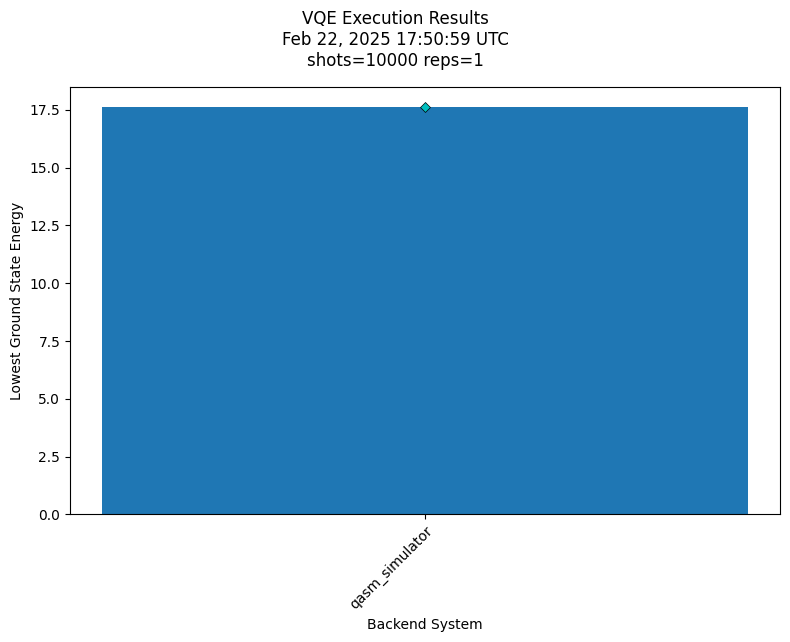

In [17]:
import time
from time import gmtime, strftime
from datetime import datetime
import matplotlib.pyplot as plt

NUM_SHOTS = num_shots
NUM_REPS = 1

# Get the current time formatted
def get_timestr():
    #timestr = strftime("%Y-%m-%d %H:%M:%S UTC", gmtime())
    timestr = strftime("%b %d, %Y %H:%M:%S UTC", gmtime())
    return timestr

# generate one-column figure with multiple bar charts, with shared X axis
def plot_results():
    
    cols = 1
    fig_w = 8.0
    
    numplots = 1
  
    rows = numplots
    
    # DEVNOTE: this calculation is based on visual assessment of results and could be refined
    # compute height needed to draw same height plots, no matter how many there are
    fig_h = 6.5 + 2.0 * (rows - 1) + 0.25 * (rows - 1)
    #print(fig_h)
    
    # create the figure into which plots will be placed
    fig, axs = plt.subplots(rows, cols, sharex=True, figsize=(fig_w, fig_h))
    
    # Create appropriate title
    suptitle = "VQE Execution Results"
    
    # append key metrics info to the title
    fulltitle = suptitle + f"\n{get_timestr()}"
    fulltitle += f"\nshots={NUM_SHOTS} reps={NUM_REPS}"

    # and add the title to the plot
    plt.suptitle(fulltitle)
    
    axi = 0
    xaxis_set = False
    
    if rows == 1:
        ax = axs
        axs = [ax]
        
    # For the y axis, choose the limits to be at least [0,40].
#     axs[axi].set_ylim([0, max(40,
#                       max(group_metrics_2["optimality_gap"]), 
#                       max(max(group_metrics_2["quantile_optgaps"]))
#                       ) * 1.1])

    #axs[axi].set_ylim([-2.0, -1.5])
    #axs[axi].set_ylim([-1.9, -1.6])
    
    #axs[axi].bar(group_metrics["groups"], group_metrics_2["optimality_gap"], 0.8)
    
    print(f"{list(energy_results.items())}")
    
    xdata = range(len(energy_results))
    xlabels = list(energy_results.keys())
    
    ydata = list(energy_results.items())

    print(f"... avgs = {er_averages}")
    
    #axs[axi].bar(group_metrics["groups"], group_metrics_2["optimality_gap"], 0.8)
    
    axs[axi].bar(xdata, er_averages, 0.7)

    # Plot the quantile optimality gaps as errorbars
    try:
#         q_vals = group_metrics_2['quantile_optgaps'] # list of lists; shape (number of circuit widths, 3)
#         # Indices are of the form (circuit width index, quantile index)
#         print(q_vals)
#         center_optgaps = [q_vals[i][1] for i in range(len(q_vals))]
#         down_error = [q_vals[i][0] - q_vals[i][1] for i in range(len(q_vals))]
#         up_error = [q_vals[i][1] - q_vals[i][2] for i in range(len(q_vals))]
#         errors = [up_error, down_error]

#         axs[axi].errorbar(group_metrics["groups"], center_optgaps, yerr = errors,
#                           ecolor = 'k', elinewidth = 1,barsabove=False, capsize=3,
#                           ls='',marker="D", markersize=5, mfc='c', mec='k', mew=0.5)
        
        #q_vals = group_metrics_2['quantile_optgaps'] # list of lists; shape (number of circuit widths, 3)
        # Indices are of the form (circuit width index, quantile index)
        #print(q_vals)
        center_optgaps = er_averages
        up_error = [er_averages[i] + er_stddevs[i] for i in range(len(er_averages))]
        down_error = [er_averages[i] - er_stddevs[i] for i in range(len(er_averages))]
        
        up_error = [er_stddevs[i] for i in range(len(er_averages))]
        down_error = [er_stddevs[i] for i in range(len(er_averages))]
        
        errors = [up_error, down_error]
        print(errors)

        axs[axi].errorbar(xdata, center_optgaps, yerr = errors,
                          ecolor = 'k', elinewidth = 1,barsabove=False, capsize=3,
                          ls='',marker="D", markersize=5, mfc='c', mec='k', mew=0.5)
        
    except Exception as e: print(e)

    #axs[axi].bar(group_metrics["groups"], group_metrics["avg_tr_depths"], 0.5, color='C9') 
    #axs[axi].set_ylabel(known_score_labels['approx_ratio'])
    axs[axi].set_ylabel('Lowest Ground State Energy')

    if rows > 0 and not xaxis_set:
        axs[axi].sharex(axs[rows-1])
        xaxis_set = True

    # Replacing legend settings. Might need to modify later
    # axs[axi].legend(['Degree 3', 'Degree -3'], loc='upper left') 
#     axs[axi].legend(['Optimality gap: metric', 'Optimality gap: quartiles'], loc='center left',
#                     bbox_to_anchor=(1, 0.5)) # For now, we are only plotting for degree 3, and not -3
    axi += 1
    
    # shared x axis label
    axs[rows - 1].set_xlabel('Backend System')
    
    ax.set_xticks(xdata)  
    plt.xticks(xdata, xlabels, color='black', rotation=45, ha='right', va='top', rotation_mode="anchor")
    
    fig.tight_layout() 
    
#     # save plot image to file
#     if save_plot_images:
#         save_plot_image(plt, f"{appname}-optgaps" + suffix, backend_id) 
            
#     # show the plot for user to see
#     if show_plot_images:
    plt.show()

plot_results()
        